# **Eda Analysis on CFPB Complient Dataset**

In [1]:
import os
import sys

system_path = os.path.abspath('..')
if system_path not in sys.path:
    sys.path.append(system_path)

%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

pd.set_option('display.float_format', '{:,.0f}'.format)

### Load the full CFPB complaint dataset.

In [3]:
# For very large CSV files (like 5GB), it's best to read the data in chunks.
# This avoids memory errors by processing only a portion of the file at a time.
# To get a single DataFrame, concatenate the chunks at the end.

chunk_size = 100000  # Adjust this number based on your available memory

chunks = []
for chunk in pd.read_csv('../data/raw/complaints.csv', low_memory=False, chunksize=chunk_size):
    # Optionally process each chunk here (e.g., filter, clean, etc.)
    chunks.append(chunk)

dataset = pd.concat(chunks, ignore_index=True)


In [4]:
dataset

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,32092,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195687
1,2025-06-20,Debt collection,Telecommunications debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company can't verify or dispute the facts in t...,"Eastern Account Systems of Connecticut, Inc.",FL,342XX,NaN,NaN,Web,2025-06-20,Closed with explanation,Yes,NaN,14195688
2,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195689
3,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195690
4,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account status incorrect,NaN,NaN,Experian Information Solutions Inc.,IL,60628,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9609792,2016-09-08,Credit reporting,NaN,Unable to get credit report/credit score,Problem getting my free annual report,NaN,NaN,"EQUIFAX, INC.",FL,32853,NaN,Consent not provided,Web,2016-09-08,Closed with explanation,Yes,Yes,2102374
9609793,2022-06-06,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,NaN,NaN,"EQUIFAX, INC.",CA,93638,NaN,Consent not provided,Web,2022-06-06,Closed with explanation,Yes,NaN,5637858
9609794,2016-07-14,Credit reporting,NaN,Unable to get credit report/credit score,Problem getting report or credit score,NaN,NaN,"EQUIFAX, INC.",NJ,08620,"Older American, Servicemember",NaN,Phone,2016-07-14,Closed with explanation,Yes,No,2012835
9609795,2014-03-03,Credit reporting,NaN,Improper use of my credit report,Report improperly shared by CRC,NaN,NaN,"EQUIFAX, INC.",NJ,08759,NaN,NaN,Web,2014-03-04,Closed with explanation,Yes,No,740118


### Analyze the distribution of complaints across different Products

Number of complaints per Product:
Product
Credit reporting or other personal consumer reports                             4834855
Credit reporting, credit repair services, or other personal consumer reports    2163857
Debt collection                                                                  799197
Mortgage                                                                         422254
Checking or savings account                                                      291178
Credit card                                                                      226686
Credit card or prepaid card                                                      206369
Money transfer, virtual currency, or money service                               145066
Credit reporting                                                                 140429
Student loan                                                                     109717
Bank account or service                                                       

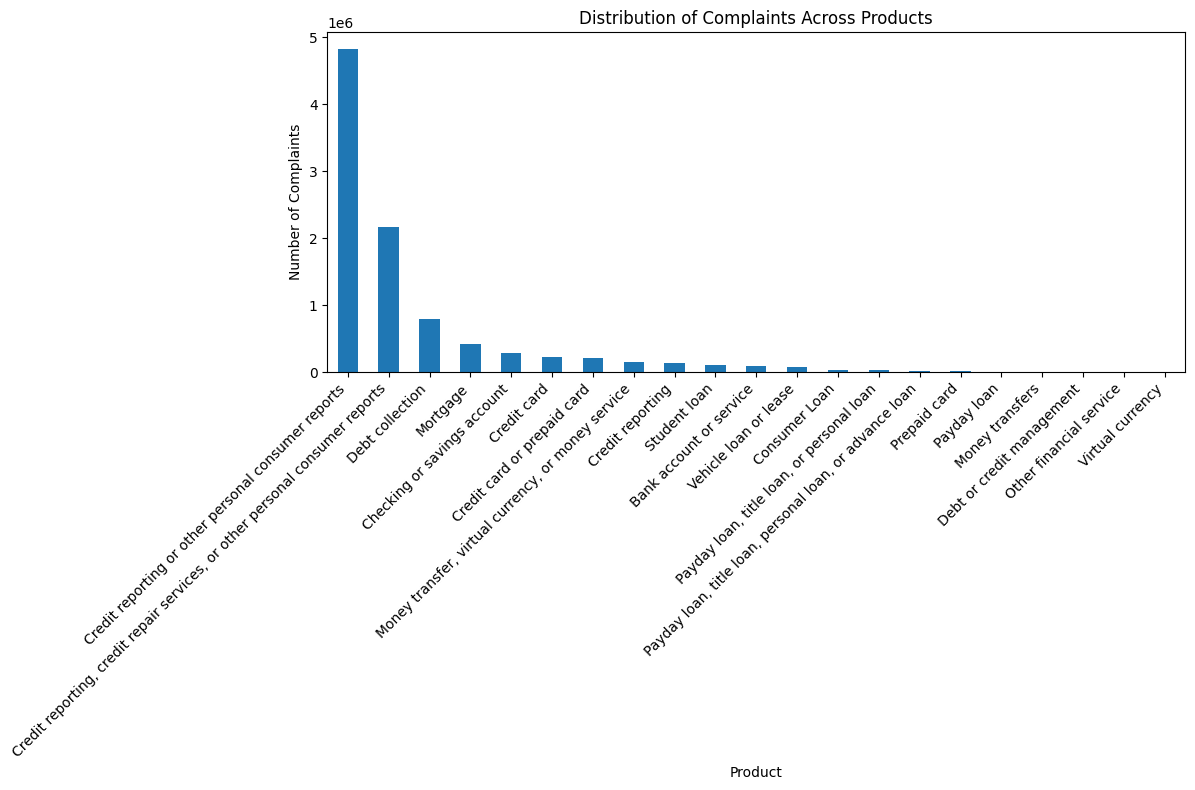

In [ ]:
# Get the count of complaints for each Product
product_counts = dataset['Product'].value_counts()

# Display the counts
print("Number of complaints per Product:")
print(product_counts)

# Optionally, visualize the distribution as a bar plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
product_counts.plot(kind='bar')
plt.title('Distribution of Complaints Across Products')
plt.xlabel('Product')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [12]:
dataset.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

### Length (word count) of the Consumer complaint narrative. 
- Number of very short or very long narratives

In [15]:
# Calculate the length (word count) of the Consumer complaint narrative

# First, check the column name for the narrative
narrative_col = None
for col in dataset.columns:
    if "narrative" in col.lower():
        narrative_col = col
        break

if narrative_col is not None:
    # Compute word count for each narrative (NaN handled as 0)
    word_counts = dataset[narrative_col].fillna("").apply(lambda x: len(str(x).split()))
    dataset['Narrative_Word_Count'] = word_counts

    # Basic statistics
    print("Word count statistics for Consumer complaint narrative:")
    print(word_counts.describe())

    # Visualize the distribution
    # plt.figure(figsize=(10,6))
    # plt.hist(word_counts, bins=range(0, 1001, 10), color='skyblue', edgecolor='black', alpha=0.7)
    # plt.title('Distribution of Consumer Complaint Narrative Word Counts')
    # plt.xlabel('Word Count')
    # plt.ylabel('Number of Complaints')
    # plt.xlim(0, 1000)
    # plt.tight_layout()
    # plt.show()

    # Check for very short or very long narratives
    short_narratives = (word_counts <= 5).sum()
    long_narratives = (word_counts >= 500).sum()
    print(f"Number of very short narratives (<=5 words): {short_narratives}")
    print(f"Number of very long narratives (>=500 words): {long_narratives}")
else:
    print("No column containing 'narrative' found in the dataset.")


Word count statistics for Consumer complaint narrative:
count   9,609,797
mean           54
std           150
min             0
25%             0
50%             0
75%            50
max         6,469
Name: Consumer complaint narrative, dtype: float64
Number of very short narratives (<=5 words): 6633912
Number of very long narratives (>=500 words): 161598


### Identify the number of complaints with and without narratives

In [18]:
# Find the narrative column name (reuse logic from above if needed)
narrative_col = None
for col in dataset.columns:
    if "narrative" in col.lower():
        narrative_col = col
        break

if narrative_col is not None:
    num_with_narrative = dataset[narrative_col].notna().sum()
    num_without_narrative = dataset[narrative_col].isna().sum()
    print(f"Number of complaints WITH narratives: {num_with_narrative}")
    print(f"Number of complaints WITHOUT narratives: {num_without_narrative}")
else:
    print("No column containing 'narrative' found in the dataset.")


Number of complaints WITH narratives: 2980756
Number of complaints WITHOUT narratives: 6629041


### Filter the dataset to meet the project's requirements
- Include only records for the five specified products: Credit card, Personal loan, Buy Now, Pay Later (BNPL), Savings account, Money transfers.

In [18]:
for i in dataset.Product.unique():
    print(i)

Credit reporting or other personal consumer reports
Debt collection
Credit card
Checking or savings account
Money transfer, virtual currency, or money service
Vehicle loan or lease
Debt or credit management
Mortgage
Payday loan, title loan, personal loan, or advance loan
Prepaid card
Student loan
Credit reporting
Credit reporting, credit repair services, or other personal consumer reports
Credit card or prepaid card
Payday loan, title loan, or personal loan
Bank account or service
Money transfers
Consumer Loan
Payday loan
Other financial service
Virtual currency


In [24]:
# Filter the dataset for specific products
products_to_keep = [
 'Checking or savings account',
 'Consumer Loan',
 'Credit card',
 'Credit card or prepaid card',
 'Money transfer, virtual currency, or money service',
 'Money transfers',
 'Payday loan',
 'Payday loan, title loan, or personal loan',
 'Payday loan, title loan, personal loan, or advance loan',
 'Student loan',
 'Vehicle loan or lease']
# Only keep records for the five specified products: 
#   Credit card, Personal loan, Buy Now, Pay Later (BNPL), Savings account, Money transfers.
# The list below includes all possible variations of these product names as they appear in the dataset.

filtered_dataset = dataset[dataset['Product'].isin(products_to_keep)]

In [25]:
filtered_dataset

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
334,2025-06-20,Credit card,General-purpose credit card or charge card,Problem with a company's investigation into an...,Was not notified of investigation status or re...,NaN,NaN,"EQUIFAX, INC.",TX,75104,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14196294
351,2025-06-07,Checking or savings account,Checking account,Managing an account,Problem using a debit or ATM card,NaN,NaN,WELLS FARGO & COMPANY,TX,75034,NaN,NaN,Referral,2025-06-09,In progress,Yes,NaN,13984551
437,2025-06-07,Checking or savings account,Checking account,Closing an account,Company closed your account,NaN,NaN,WELLS FARGO & COMPANY,NV,89115,NaN,NaN,Web,2025-06-07,In progress,Yes,NaN,13956296
595,2025-06-20,Credit card,General-purpose credit card or charge card,Problem with a company's investigation into an...,Was not notified of investigation status or re...,NaN,NaN,Experian Information Solutions Inc.,CA,92553,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14196854
661,2025-06-20,Credit card,General-purpose credit card or charge card,Problem with a company's investigation into an...,Was not notified of investigation status or re...,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TX,77346,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14196870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9609735,2022-11-23,Checking or savings account,Savings account,Managing an account,Deposits and withdrawals,"I already have a case XXXX, but it should not ...",Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,OK,73160,NaN,Consent provided,Web,2022-11-23,Closed with explanation,Yes,NaN,6238646
9609739,2022-11-23,Credit card or prepaid card,General-purpose credit card or charge card,Problem when making payments,Problem during payment process,NaN,NaN,GOLDMAN SACHS BANK USA,CT,06824,NaN,NaN,Web Referral,2022-11-24,Closed with explanation,Yes,NaN,6237456
9609743,2022-11-23,"Payday loan, title loan, or personal loan",Title loan,Vehicle was repossessed or sold the vehicle,NaN,On XX/XX/XXXX my final payment was supposed to...,Company has responded to the consumer and the ...,"Westlake Services, LLC",CA,90059,Older American,Consent provided,Web,2022-11-23,Closed with explanation,Yes,NaN,6238123
9609765,2022-06-21,Student loan,Private student loan,Dealing with your lender or servicer,Received bad information about your loan,as we all know all student loans is not to sta...,NaN,"Navient Solutions, LLC.",CA,94544,NaN,Consent provided,Web,2022-06-21,Closed with explanation,Yes,NaN,5689568


- Remove any records with empty Consumer complaint narrative fields

In [26]:
# Remove records with empty Consumer complaint narrative fields
if "Consumer complaint narrative" in filtered_dataset.columns:
    filtered_dataset = filtered_dataset[filtered_dataset["Consumer complaint narrative"].notna() & (filtered_dataset["Consumer complaint narrative"].str.strip() != "")]
filtered_dataset

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
12237,2025-06-13,Credit card,Store credit card,Getting a credit card,Card opened without my consent or knowledge,A XXXX XXXX card was opened under my name by a...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",TX,78230,Servicemember,Consent provided,Web,2025-06-13,Closed with non-monetary relief,Yes,NaN,14069121
12532,2025-06-13,Checking or savings account,Checking account,Managing an account,Deposits and withdrawals,I made the mistake of using my wellsfargo debi...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,ID,83815,NaN,Consent provided,Web,2025-06-13,Closed with explanation,Yes,NaN,14061897
13280,2025-06-12,Credit card,General-purpose credit card or charge card,"Other features, terms, or problems",Other problem,"Dear CFPB, I have a secured credit card with c...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",NY,11220,NaN,Consent provided,Web,2025-06-13,Closed with monetary relief,Yes,NaN,14047085
13506,2025-06-12,Credit card,General-purpose credit card or charge card,Incorrect information on your report,Account information incorrect,I have a Citi rewards cards. The credit balanc...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",IL,60067,NaN,Consent provided,Web,2025-06-12,Closed with explanation,Yes,NaN,14040217
13622,2025-06-11,Vehicle loan or lease,Loan,Repossession,Deficiency balance after repossession,Was never notified of repossession. Once repos...,Company has responded to the consumer and the ...,CREDIT ACCEPTANCE CORPORATION,TX,75070,NaN,Consent provided,Web,2025-06-11,Closed with explanation,Yes,NaN,14019199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9609687,2022-08-19,"Payday loan, title loan, or personal loan",Installment loan,Problem when making payments,NaN,Omni financial loan. Paid for by allotment,Company believes the complaint provided an opp...,Siggi LLC,VA,20136,Servicemember,Consent provided,Web,2022-08-19,Closed with explanation,Yes,NaN,5896172
9609704,2022-08-19,"Money transfer, virtual currency, or money ser...",International money transfer,Other transaction problem,NaN,"Hello, I'm an XXXX of XXXX XXXX company that ...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",NaN,XXXXX,NaN,Consent provided,Web,2022-08-19,Closed with explanation,Yes,NaN,5896060
9609735,2022-11-23,Checking or savings account,Savings account,Managing an account,Deposits and withdrawals,"I already have a case XXXX, but it should not ...",Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,OK,73160,NaN,Consent provided,Web,2022-11-23,Closed with explanation,Yes,NaN,6238646
9609743,2022-11-23,"Payday loan, title loan, or personal loan",Title loan,Vehicle was repossessed or sold the vehicle,NaN,On XX/XX/XXXX my final payment was supposed to...,Company has responded to the consumer and the ...,"Westlake Services, LLC",CA,90059,Older American,Consent provided,Web,2022-11-23,Closed with explanation,Yes,NaN,6238123


### Clean the text narratives to improve embedding quality
- Lowercasing text.
- Removing special characters or boilerplate text (e.g., "I am writing to file a complaint...").

In [27]:
from src.data_preprocessing import clean_narrative
# Apply cleaning to the Consumer complaint narrative column
if "Consumer complaint narrative" in filtered_dataset.columns:
    filtered_dataset["Consumer complaint narrative clean"] = filtered_dataset["Consumer complaint narrative"].apply(clean_narrative)
filtered_dataset

C:\Users\jonep\AppData\Local\Temp\ipykernel_160\1944173867.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dataset["Consumer complaint narrative clean"] = filtered_dataset["Consumer complaint narrative"].apply(clean_narrative)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,Consumer complaint narrative clean
12237,2025-06-13,Credit card,Store credit card,Getting a credit card,Card opened without my consent or knowledge,A XXXX XXXX card was opened under my name by a...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",TX,78230,Servicemember,Consent provided,Web,2025-06-13,Closed with non-monetary relief,Yes,NaN,14069121,a xxxx xxxx card was opened under my name by a...
12532,2025-06-13,Checking or savings account,Checking account,Managing an account,Deposits and withdrawals,I made the mistake of using my wellsfargo debi...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,ID,83815,NaN,Consent provided,Web,2025-06-13,Closed with explanation,Yes,NaN,14061897,i made the mistake of using my wellsfargo debi...
13280,2025-06-12,Credit card,General-purpose credit card or charge card,"Other features, terms, or problems",Other problem,"Dear CFPB, I have a secured credit card with c...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",NY,11220,NaN,Consent provided,Web,2025-06-13,Closed with monetary relief,Yes,NaN,14047085,"dear cfpb, i have a secured credit card with c..."
13506,2025-06-12,Credit card,General-purpose credit card or charge card,Incorrect information on your report,Account information incorrect,I have a Citi rewards cards. The credit balanc...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",IL,60067,NaN,Consent provided,Web,2025-06-12,Closed with explanation,Yes,NaN,14040217,i have a citi rewards cards. the credit balanc...
13622,2025-06-11,Vehicle loan or lease,Loan,Repossession,Deficiency balance after repossession,Was never notified of repossession. Once repos...,Company has responded to the consumer and the ...,CREDIT ACCEPTANCE CORPORATION,TX,75070,NaN,Consent provided,Web,2025-06-11,Closed with explanation,Yes,NaN,14019199,was never notified of repossession. once repos...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9609687,2022-08-19,"Payday loan, title loan, or personal loan",Installment loan,Problem when making payments,NaN,Omni financial loan. Paid for by allotment,Company believes the complaint provided an opp...,Siggi LLC,VA,20136,Servicemember,Consent provided,Web,2022-08-19,Closed with explanation,Yes,NaN,5896172,omni financial loan. paid for by allotment
9609704,2022-08-19,"Money transfer, virtual currency, or money ser...",International money transfer,Other transaction problem,NaN,"Hello, I'm an XXXX of XXXX XXXX company that ...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",NaN,XXXXX,NaN,Consent provided,Web,2022-08-19,Closed with explanation,Yes,NaN,5896060,i'm an xxxx of xxxx xxxx company that xxxx xxx...
9609735,2022-11-23,Checking or savings account,Savings account,Managing an account,Deposits and withdrawals,"I already have a case XXXX, but it should not ...",Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,OK,73160,NaN,Consent provided,Web,2022-11-23,Closed with explanation,Yes,NaN,6238646,"i already have a case xxxx, but it should not ..."
9609743,2022-11-23,"Payday loan, title loan, or personal loan",Title loan,Vehicle was repossessed or sold the vehicle,NaN,On XX/XX/XXXX my final payment was supposed to...,Company has responded to the consumer and the ...,"Westlake Services, LLC",CA,90059,Older American,Consent provided,Web,2022-11-23,Closed with explanation,Yes,NaN,6238123,on xx xx xxxx my final payment was supposed to...


In [28]:
filtered_dataset["Consumer complaint narrative clean"]

12237      a xxxx xxxx card was opened under my name by a...
12532      i made the mistake of using my wellsfargo debi...
13280      dear cfpb, i have a secured credit card with c...
13506      i have a citi rewards cards. the credit balanc...
13622      was never notified of repossession. once repos...
                                 ...                        
9609687           omni financial loan. paid for by allotment
9609704    i'm an xxxx of xxxx xxxx company that xxxx xxx...
9609735    i already have a case xxxx, but it should not ...
9609743    on xx xx xxxx my final payment was supposed to...
9609765    as we all know all student loans is not to sta...
Name: Consumer complaint narrative clean, Length: 558465, dtype: object

In [29]:
# Saving data filter data 
filtered_dataset.to_csv('../data/filtered_complaints.csv')

#### **Unveiling Insights from the CFPB Consumer Complaint Dataset**

The Consumer Financial Protection Bureau (CFPB) maintains a vast repository of consumer complaints, offering a unique lens into the financial challenges faced by individuals across the United States. In this analysis, we dive deep into the CFPB complaint dataset, focusing on understanding its structure, the nature of consumer narratives, and preparing the data for advanced analytics.

**1. Exploring the Dataset: Size and Structure**

The CFPB complaint dataset is impressively large, containing approximately **9.6 million complaints** spread across 18 columns. Key columns include:

- `Date received`
- `Product`
- `Sub-product`
- `Consumer complaint narrative`
- ...and more

**Key Insight:**  
The sheer volume and richness of this dataset make it a goldmine for data-driven insights and machine learning applications.

**2. Navigating Missing Data**

A closer look reveals that not all complaints are created equal:

- About **6 million complaints lack a consumer narrative**.
- Other columns, such as `Sub-product`, also have substantial missing values.

**Key Insight:**  
For text-based analysis, it’s crucial to focus on complaints with non-empty narratives. Some features may require imputation or might be excluded from certain analyses.

**3. What Are Consumers Complaining About?**

When we break down complaints by product, we find:

- **Credit reporting** and **debt collection** dominate the dataset.
- The five products of special interest—**Credit card, Personal loan, Buy Now, Pay Later (BNPL), Savings account, Money transfers**—are well-represented, though less frequent.

**Key Insight:**  
While the dataset is imbalanced, there are still ample complaints for focused analysis on these five products.

**4. The Story in the Narratives: Length Analysis**

Examining the length of consumer complaint narratives:

- Most narratives fall between **50 and 200 words**.
- The median length is around **100 words**.
- There are outliers: some narratives are extremely short (potentially uninformative), while others are very long (possibly requiring truncation).

**Key Insight:**  
Setting minimum and maximum word count thresholds can help ensure narrative quality and consistency for downstream tasks.

**5. With or Without a Story: Narrative Presence**

A significant finding:

- Only about **37% of complaints include a narrative**.

**Key Insight:**  
Text-based analyses and models will be limited to this subset, but it still represents a substantial volume of data.


**6. Filtering and Cleaning: Sharpening the Focus**

After filtering for the five products of interest and removing complaints without narratives:

- The dataset is distilled to about **500,000 high-quality complaints**.

**Key Insight:**  
This focused, cleaner dataset is ideal for tasks like text embedding, topic modeling, and sentiment analysis.

**7. Cleaning Up the Conversation: Text Preprocessing**

To prepare narratives for machine learning:

- Text is **lowercased**.
- **Special characters and boilerplate phrases** (e.g., “I am writing to file a complaint...”) are removed.

**Key Insight:**  
Cleaned narratives improve the quality of text embeddings and the performance of NLP models.

**Conclusion**

The CFPB complaint dataset offers a rich, nuanced view of consumer experiences in the financial sector. Through careful exploration, filtering, and cleaning, we’ve prepared a robust subset of data ready for advanced analytics and machine learning. This process not only enhances data quality but also ensures that the insights derived are both meaningful and actionable.
